# Bank account fraud classification

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler # For z-score normalizing the Pandas dataframe
from sklearn.feature_selection import VarianceThreshold # VarianceThreshold used to get rid of columns that hold no variance thus contributing no new information
from imblearn.over_sampling import SMOTE # Use for oversampling the data (generate synthetic data for fraud) to address imbalanced data
from imblearn.under_sampling import RandomUnderSampler # Use for undersampling the data (simply take an equal amount of both classes) to address imbalanced data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## 1. Data exploration

In [4]:
df = pd.read_csv("Base.csv")
pd.set_option('display.max_columns', 70) # Want to be able to see all the columns, and prepare to be able to see columns that are one hot encoded

#### There are non-quantitative variables that need to be processed

In [ ]:
# Display the first 5 rows to get a look at the columns
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [ ]:
df['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

#### Following plot shows that the number of fraud data points is about 1% of the entire dataset, thus, accuracy is not a good indicator of model performance

<Axes: xlabel='fraud_bool'>

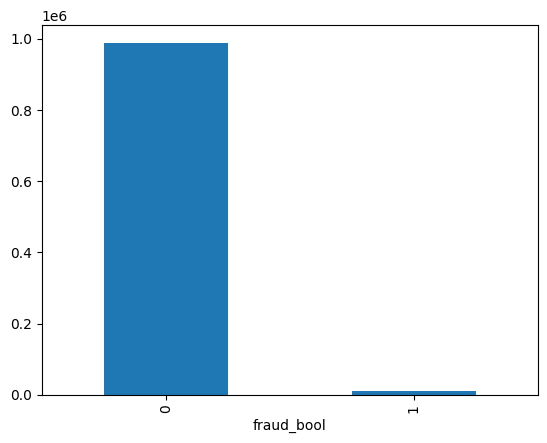

In [ ]:
df['fraud_bool'].value_counts().plot(kind='bar') # This is an extremely imbalanced dataset

In [ ]:
df.info() # Get information about the variables and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
df.nunique() # Check how many unique values each of these columns have

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

In [ ]:
df.describe(include=["object", "bool"]) # Get basic statistical information about the columns that aren't quantitative

,payment_type,employment_status,housing_status,source,device_os
count,1000000,1000000,1000000,1000000,1000000
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,370554,730252,372143,992952,342728


In [ ]:
nan_map = df.isna().sum() # Check for NaN values, there shouldn't be any since this is a synthetic dataset but want to make sure
nan_map

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

#### Note: I won't attempt to remove outliers as the entire point of a dataset like this is likely to explore the defining features of outliers. A technique like Isolation Forest is supposed to do just that

## 2. Data Preprocessing

### One hot encode categorical features

Create new columns for each categorical feature, using a 1 to represent it's presence in a row and 0 to represent the fact that it's not there. We need to do this to have a numeric value for these columns as most models rely on numerical data.

So if a categorical column has 3 values, create 3 columns that are one hot encoded for each of the 3 values

In [ ]:
qualitative = [i for i in df.columns if df[i].dtypes == "object"]

print(qualitative)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [ ]:
df = pd.DataFrame(pd.get_dummies(df, prefix=qualitative)) # One hot encode the qualitative features using panda's get_dummies method

In [ ]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False


### Use VarianceThreshold to see if there are features we should remove

If it has no variance then we should drop it from the dataset since they don't contribute any meaningful information but just add more redundancy to the dataset

In [ ]:
variance = VarianceThreshold()
variance.fit(df)
features_to_remove = [f for f in df.columns if f not in df.columns[variance.get_support()]] # Go through all original dataframe columns and see if they are in the columns of variance.get_support, which gets the features selected that has a variance

print(features_to_remove)

['device_fraud_count']


In [ ]:
df = df.drop(['device_fraud_count'], axis=1) # Drop device_fraud_count since it contains no variance
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False


### Feature Engineer

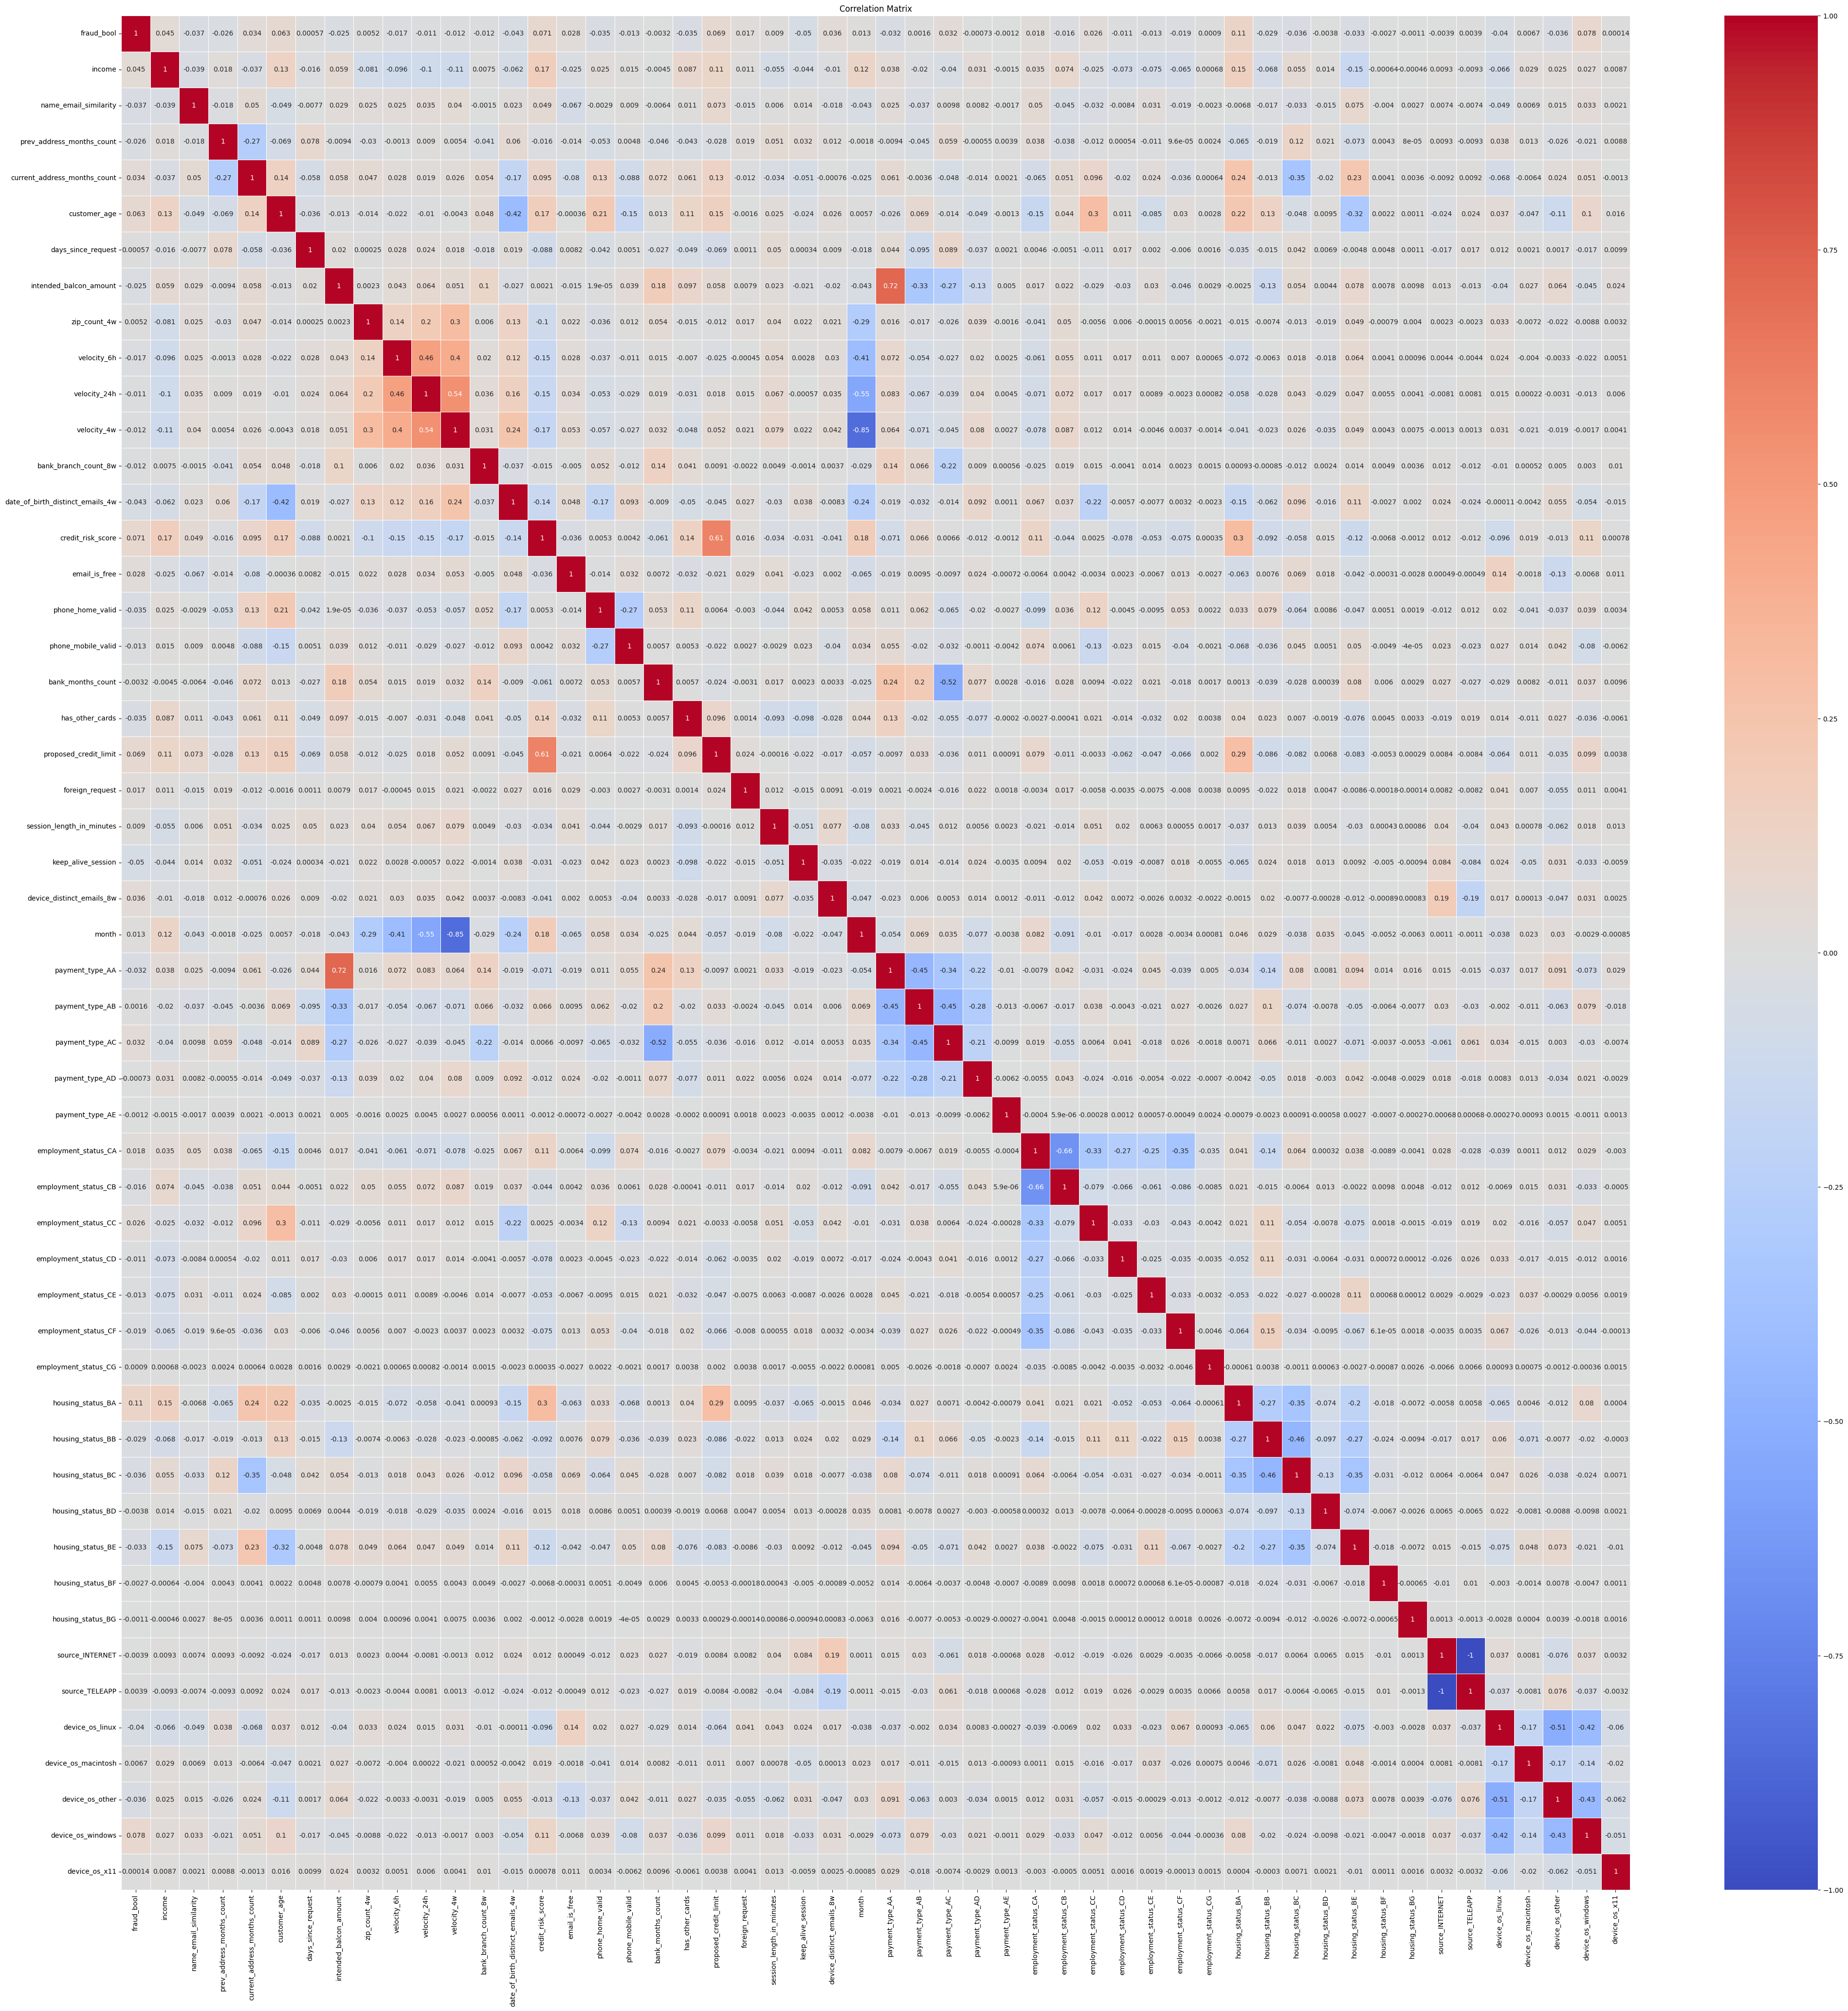

In [ ]:
plt.figure(figsize=(50, 50))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr = df.corr()
# Find features with strong correlation with target
target_corr = corr['fraud_bool'].abs().sort_values(ascending=False)
strong_corr_features = target_corr.index[1:11] 

print('Top 10 features with highest correlation with target:')
for feature in strong_corr_features:
    print(f"{feature}: {target_corr[feature]}")
    

Top 10 features with highest correlation with target:
housing_status_BA: 0.11442817716443898
device_os_windows: 0.07826333796376525
credit_risk_score: 0.07062363179619084
proposed_credit_limit: 0.06890662898976282
customer_age: 0.06295865025001542
keep_alive_session: 0.0502964128195964
income: 0.04507917449209994
date_of_birth_distinct_emails_4w: 0.04322370563628376
device_os_linux: 0.03971738420174538
name_email_similarity: 0.03671963583495697


In [ ]:
features = [
    "fraud_bool",
    "housing_status_BA",
    "device_os_windows",
    "credit_risk_score",
    "customer_age",
    "credit_risk_score",
    "keep_alive_session",
    "income",
    "date_of_birth_distinct_emails_4w",
    "device_os_linux",
    "name_email_similarity",
]
processed_df = df[features]
processed_df.head()

,fraud_bool,housing_status_BA,device_os_windows,credit_risk_score,customer_age,credit_risk_score,keep_alive_session,income,date_of_birth_distinct_emails_4w,device_os_linux,name_email_similarity
0,0,False,False,163,40,163,1,0.3,5,True,0.986506
1,0,False,False,154,20,154,1,0.8,18,False,0.617426
2,0,False,True,89,40,89,0,0.8,11,False,0.996707
3,0,False,False,90,30,90,1,0.6,13,True,0.475100
4,0,False,False,91,40,91,0,0.9,6,False,0.842307


#### Create the training and test data

In [ ]:
# First split the data into the features and the true labels for each row
X = processed_df.drop('fraud_bool', axis=1).applymap(float)
Y = processed_df['fraud_bool']
X.head()

C:\Users\kevxe\AppData\Local\Temp\ipykernel_13464\2520017094.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = processed_df.drop('fraud_bool', axis=1).applymap(float)


,housing_status_BA,device_os_windows,credit_risk_score,customer_age,credit_risk_score,keep_alive_session,income,date_of_birth_distinct_emails_4w,device_os_linux,name_email_similarity
0,0.0,0.0,163.0,40.0,163.0,1.0,0.3,5.0,1.0,0.986506
1,0.0,0.0,154.0,20.0,154.0,1.0,0.8,18.0,0.0,0.617426
2,0.0,1.0,89.0,40.0,89.0,0.0,0.8,11.0,0.0,0.996707
3,0.0,0.0,90.0,30.0,90.0,1.0,0.6,13.0,1.0,0.475100
4,0.0,0.0,91.0,40.0,91.0,0.0,0.9,6.0,0.0,0.842307


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#### Address imbalanced data with SMOTE: Synthetic Minority Over-sampling Technique

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address imbalanced datasets. It generates synthetic examples to help balance the distribution of classes in a dataset, thereby improving the performance of machine learning models that are sensitive to class imbalance.

### How SMOTE Works

1. **Identify Nearest Neighbors**:
   - For each sample in the minority class, SMOTE identifies a set number of nearest neighbors from the same class.

2. **Generate Synthetic Samples**:
   - Synthetic samples are created by interpolating between the original sample and one of its nearest neighbors. The synthetic sample is calculated by taking a linear combination of the two samples.
   - The formula to generate a synthetic sample is: `synthetic` = sample + λ x (neighbor−sample)
   where:
     - `λ` is a random value between 0 and 1,
     - `sample` is the original minority class sample,
     - `neighbor` is one of its identified nearest neighbors.

3. **Balancing the Dataset**:
   - The process is repeated to generate enough synthetic samples to balance the classes.

Increases Diversity: By generating synthetic samples through interpolation, SMOTE creates a more diverse set of samples, reducing the risk of overfitting.
Balances the Dataset: It helps to achieve a more balanced dataset, improving the performance of machine learning algorithms, especially those sensitive to class imbalance.
Preserves Distribution: Since SMOTE interpolates between existing samples, it tends to maintain the general distribution and structure of the minority class.

Noise Sensitivity: If the minority class contains noise or outliers, SMOTE may propagate this noise into the synthetic samples.
Boundary Effects: SMOTE could generate synthetic samples that cross class boundaries, especially if the dataset has overlapping classes.
Parameter Tuning: Selecting the number of nearest neighbors (k) and the number of synthetic samples to generate can require careful tuning.


In [ ]:
# Apply oversampling with SMOTE
smote = SMOTE(random_state=42)
X_smote, Y_smote = smote.fit_resample(X_train, Y_train)

In [ ]:
print(len(X_smote))
print(len(Y_smote))

1384370
1384370


### Address the data imbalance with UNDER sampling

Basically just sample less from the negative dataset (non fraud) to balance it out against the oversampled data

In [ ]:
under_sampler = RandomUnderSampler(random_state=42)
X_under, Y_under = under_sampler.fit_resample(X_train, Y_train)

In [ ]:
print(len(X_under))
print(len(Y_under))

15630
15630


### Z-score normalize the data

Normalize the data to prevent one feature from holding too much weight over others

In [ ]:
z_score_normalizer = StandardScaler()
X_train_smote = z_score_normalizer.fit_transform(X_smote)
X_test_smote = z_score_normalizer.transform(X_test.copy())

In [ ]:
z_score_normalizer = StandardScaler()
X_train_under = z_score_normalizer.fit_transform(X_under) # For some reason couldn't get it to work if I just explicitly said "df = z_score_norm.fit...(df)", had to manually grab the columns in a list
X_test_under = z_score_normalizer.transform(X_test.copy())

In [ ]:
z_score_normalizer = StandardScaler()
X_train_iso = z_score_normalizer.fit_transform(X_train) # For some reason couldn't get it to work if I just explicitly said "df = z_score_norm.fit...(df)", had to manually grab the columns in a list
X_test_iso = z_score_normalizer.transform(X_test.copy())

## 3. Training models

In [ ]:
LR_smote = LogisticRegression(class_weight='balanced')  # Example with logistic regression on SMOTE data
LR_smote.fit(X_train_smote, Y_smote)
Y_pred = LR_smote.predict(X_test_smote)
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
print(roc_auc_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87    296786
           1       0.03      0.72      0.06      3214

    accuracy                           0.78    300000
   macro avg       0.52      0.75      0.47    300000
weighted avg       0.99      0.78      0.86    300000

[[230654  66132]
 [   885   2329]]
0.7509074840542981


In [ ]:
LR_under = LogisticRegression(class_weight='balanced')  # Example with logistic regression on under sampled data
LR_under.fit(X_train_under, Y_under)
Y_pred = LR_under.predict(X_test_under)
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
print(roc_auc_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87    296786
           1       0.03      0.73      0.06      3214

    accuracy                           0.77    300000
   macro avg       0.51      0.75      0.47    300000
weighted avg       0.99      0.77      0.86    300000

[[229189  67597]
 [   858   2356]]
0.7526397490868685


In [ ]:
XG_under = RandomForestClassifier(class_weight='balanced')  # Example with logistic regression on under sampled data
XG_under.fit(X_train_under, Y_under)
Y_pred = XG_under.predict(X_test_under)
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
print(roc_auc_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    296786
           1       0.03      0.73      0.06      3214

    accuracy                           0.76    300000
   macro avg       0.51      0.74      0.46    300000
weighted avg       0.99      0.76      0.85    300000

[[224533  72253]
 [   867   2347]]
0.7433955888614799


In [ ]:
isf = IsolationForest(random_state=42)
isf.fit(X_train_iso, Y_train) # Test on the entire dataset as that's the nature of Isolation Forest
Y_pred = isf.predict(X_test_iso)
Y_pred_binary = np.where(Y_pred == -1, 1, 0)
print(classification_report(Y_test, Y_pred_binary))
print(confusion_matrix(Y_test, Y_pred_binary))
print(roc_auc_score(Y_test, Y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      0.52      0.68    296786
           1       0.02      0.83      0.04      3214

    accuracy                           0.52    300000
   macro avg       0.51      0.68      0.36    300000
weighted avg       0.99      0.52      0.67    300000

[[153676 143110]
 [   533   2681]]
0.675981870799688


## Use deep learning with PyTorch

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader # Turn data into Datasets and Dataloaders
# import torch.optim as optim
# import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# print(X_smote.dtypes)
# print(Y_smote.dtypes)

housing_status_BA                   float64
device_os_windows                   float64
credit_risk_score                   float64
customer_age                        float64
credit_risk_score                   float64
keep_alive_session                  float64
income                              float64
date_of_birth_distinct_emails_4w    float64
device_os_linux                     float64
name_email_similarity               float64
dtype: object
int64


In [ ]:
# Turn all of these into tensors
# X_train_tensors = torch.tensor(X_smote.values, dtype=torch.float)
# X_test_tensors = torch.tensor(X_test.values, dtype=torch.float)
# Y_train_tensors = torch.tensor(Y_smote.values, dtype=torch.long)
# Y_test_tensors = torch.tensor(Y_test.values, dtype=torch.long)

In [ ]:
# print(X_train_tensors)

tensor([[1.0000e+00, 1.0000e+00, 2.6700e+02,  ..., 6.0000e+00, 0.0000e+00,
         8.6713e-01],
        [0.0000e+00, 0.0000e+00, 2.5000e+01,  ..., 1.2000e+01, 0.0000e+00,
         6.8357e-01],
        [1.0000e+00, 0.0000e+00, 1.9800e+02,  ..., 1.1000e+01, 1.0000e+00,
         2.0894e-01],
        ...,
        [8.7566e-01, 0.0000e+00, 1.0450e+02,  ..., 3.0632e+01, 0.0000e+00,
         7.6208e-01],
        [1.0000e+00, 2.6992e-01, 3.3973e+02,  ..., 3.2699e+00, 7.3008e-01,
         1.3707e-01],
        [2.5342e-01, 0.0000e+00, 2.0875e+02,  ..., 8.0000e+00, 0.0000e+00,
         3.9566e-01]])


In [ ]:
# print(Y_train_tensors)

tensor([0, 0, 0,  ..., 1, 1, 1])


In [ ]:
train_loader = DataLoader(TensorDataset(X_train_tensors, Y_train_tensors), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensors, Y_test_tensors), batch_size=32, shuffle=True)

In [ ]:
# print(len(train_loader))

43262


In [ ]:
# class Custom_DNN(nn.Module):
#     def __init__(self, num_classes, num_features):
#         super(Custom_DNN, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(num_features, 256),  # Increased hidden units
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.3),  # Slightly increased dropout for deeper model

#             nn.Linear(256, 128),  # Adding more layers
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.3),

#             nn.Linear(128, 64),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(64),
#             nn.Dropout(0.3),

#             nn.Linear(64, 32),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(32),
#             nn.Dropout(0.3),
            
#             nn.Linear(32, 16),  # Another additional layer
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(16),
#             nn.Dropout(0.3),

#             nn.Linear(16, num_classes)  # Output layer
#         )

#     def forward(self, x):
#         return self.network(x)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU

In [ ]:
# model = Custom_DNN(num_classes = 2, num_features=10)
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=0.1, weight_decay=0.001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # Decrease the learning rate every 10 epochs
# epochs = 100

# best_accuracy = 0.0 
# # Loop through the epochs
# for epoch in range(epochs):
#     running_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0

#     # Loop through each batch
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()  # Zero the gradients before backpropagation
#         outputs = model(inputs)  # Forward pass
#         loss = loss_function(outputs, targets)  # Compute the loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update the weights
        
#         running_loss += loss.item()  # Accumulate loss

#         _, predicted = torch.max(outputs, 1) # Calculate the accuracy as well
#         correct_predictions += (predicted == targets).sum().item()
#         total_predictions += targets.size(0)

#     epoch_accuracy = correct_predictions/total_predictions
#     print("ACCURACY", correct_predictions/total_predictions)
#     print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
#     if epoch_accuracy > best_accuracy:
#         best_accuracy = epoch_accuracy
#         # Save the model
#         torch.save(model.state_dict(), 'best_model.pth')
#         print("Saved the model with best accuracy.")
#     scheduler.step()

KeyboardInterrupt: 

In [ ]:
# model_path = 'best_model.pth'
# eval_model = Custom_DNN(num_classes = 2, num_features=10)
# eval_model.load_state_dict(torch.load(model_path))
# eval_model.eval()
# criterion = nn.CrossEntropyLoss() 

In [ ]:
# # Accumulate predictions and true labels
# all_preds = []
# all_true_labels = []

# with torch.no_grad():  # No need to compute gradients during inference
#     for inputs, labels in test_loader:
#         # Forward pass through the model
#         outputs = model(inputs)

#         # If it's a binary classification, use sigmoid to convert logits to probabilities
#         probabilities = torch.sigmoid(outputs)

#         # Collect the predictions and true labels
#         all_preds.append(probabilities.cpu().numpy())
#         all_true_labels.append(labels.cpu().numpy())
        
# # Concatenate all predictions and labels
# all_preds = np.concatenate(all_preds)
# all_true_labels = np.concatenate(all_true_labels)

In [ ]:
# print(all_preds)

[[0.42959785 0.61412036]
 [0.4016507  0.6456375 ]
 [0.5789118  0.4137124 ]
 ...
 [0.44179982 0.58031726]
 [0.46926546 0.5826974 ]
 [0.4346338  0.619619  ]]


In [ ]:
# higher_value_index = np.argmax(all_preds, axis=1) # Choose the index with the higher value
# print(higher_value_index)

[1 1 0 ... 1 1 1]


In [ ]:
# roc_auc = roc_auc_score(all_true_labels, higher_value_index)

# print("ROC AUC Score:", roc_auc)

ValueError: y should be a 1d array, got an array of shape (300000, 2) instead.